<h2 align="center">Phase 1: AtliQo Bank Credit Card Launch</h2>

Objective: Analyze customers' transactions and credit profiles to figure out a target group for the launch of AtliQo bank credit card

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Data Import

We got the dataset in two formats (1) CSV (2) MySQL. I will show you how to import data from both. You can use only one method out of these two.

##### Option 1. Read data from CSV

In [2]:
df_cust = pd.read_csv('../data/customers.csv')
df_cs = pd.read_csv('../data/credit_profiles.csv')
df_trans = pd.read_csv('../data/transactions.csv')

##### Option 2. Read it from MySQL

In [3]:
import mysql.connector

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    passwd='abc@123',
    database='e_master_card'
)

df_cust = pd.read_sql("SELECT * FROM customers", conn)
df_cust.head(3)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211,Married
1,2,Anjali Pandey,Female,47,City,Consultant,65172,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378,Married


In [4]:
df_trans = pd.read_sql("SELECT * FROM transactions", conn)
df_trans.head(3)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe


In [5]:
df_cs = pd.read_sql("SELECT * FROM credit_profiles", conn)
df_cs.head(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0


In [6]:
# when you are done importing the data, close the connection
conn.close()

In [7]:
print("Customers data",df_cust.shape)
print("Credit Score data",df_cs.shape)
print("Transactions data",df_trans.shape)

Customers data (1000, 8)
Credit Score data (1004, 6)
Transactions data (500000, 7)


In [9]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211,Married
1,2,Anjali Pandey,Female,47,City,Consultant,65172,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378,Married
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563,Married
4,5,Advait Malik,Male,48,City,Consultant,39406,Married


In [10]:
df_cs.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


In [318]:
df_trans.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


### Explore Customers Table

In [11]:
df_cust.head(3)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211,Married
1,2,Anjali Pandey,Female,47,City,Consultant,65172,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378,Married


In [12]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,132439.799000
std,288.819436,15.666155,113706.313793
min,1.000000,1.000000,0.000000
25%,250.750000,26.000000,42229.750000
50%,500.500000,32.000000,107275.000000
75%,750.250000,46.000000,189687.500000
max,1000.000000,135.000000,449346.000000


#### 1. Analyze Income Column

##### Handle Null Values: Annual income

Now let us check if any of our dataframe columns contain null values

In [14]:
df_cust.isnull().sum()

cust_id           0
name              0
gender            0
age               0
location          0
occupation        0
annual_income     0
marital_status    0
dtype: int64

Ahh.. 50 null values in annual_income. Let's quickly explore those rows

In [15]:
df_cust[df_cust.annual_income.isna()].head(4)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


We can handle these null values using different ways,

1. **Remove them**: Since there are 50 of them in a dataframe of 1000, we will not remove them as we don't want to loose some important records
1. **Replace them with mean or median**: It is suggested with use median in the case of income. This is because in an income data there could be outliers and median is more robust to these outliers
1. **Replace them with median per occupation**: Occupation wise median income can vary. It is best to use a median per occupation for replacement

In [16]:
occupation_wise_inc_median = df_cust.groupby("occupation")["annual_income"].median()
occupation_wise_inc_median

occupation
Accountant              65265.0
Artist                  44915.0
Business Owner         254881.0
Consultant              51175.0
Data Scientist         127889.0
Freelancer              45189.5
Fullstack Developer     74457.0
Name: annual_income, dtype: float64

In [17]:
occupation_wise_inc_median['Artist']

44915.0

In [18]:
# 2. Replace null values in annual_income with the median income of their occupation group
df_cust['annual_income'] = df_cust.apply(
    lambda row: occupation_wise_inc_median[row['occupation']] if pd.isnull(row['annual_income']) else row['annual_income'],
    axis=1
)

In [19]:
df_cust.iloc[[1,29]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
1,2,Anjali Pandey,Female,47,City,Consultant,65172,Single
29,30,Aditya Kulkarni,Male,31,Rural,Data Scientist,105583,Married


Previously records at location 1 and 29 had null annual income. Now you have a median value per occupation

In [20]:
df_cust.isnull().sum()

cust_id           0
name              0
gender            0
age               0
location          0
occupation        0
annual_income     0
marital_status    0
dtype: int64

Awesome 😀 Number of null values in all the columns is zero now! Hurray 🥳

Now that there are no null values, let us view the distribution of annual income

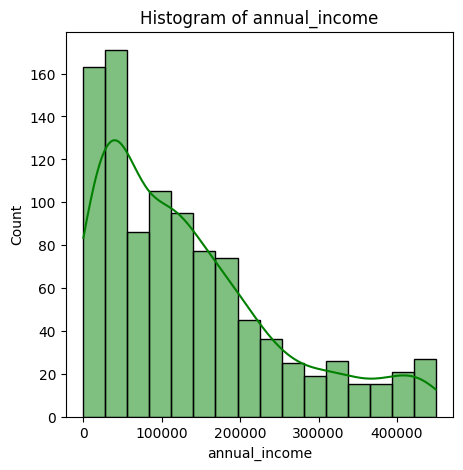

In [21]:
plt.figure(figsize=(5, 5))
sns.histplot(df_cust['annual_income'], kde=True, color='green', label='Data')
plt.title('Histogram of annual_income')
plt.show()

**You can see above that the income distribution is right skewed**

Let us now use describe() function to check some quick stats

In [329]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,138916.765500
std,288.819436,15.666155,110969.408643
min,1.000000,1.000000,2.000000
25%,250.750000,26.000000,48229.500000
50%,500.500000,32.000000,113416.000000
75%,750.250000,46.000000,192614.000000
max,1000.000000,135.000000,449346.000000


We have following observations from the above,

1. **Age**: min = 1, max = 135
1. **Annual Income**: min = 2, max = 447 k

Age column has outliers. Annual income also seem to have outliers in terms of minimum value because business suggested that minimum income should be atleast 100

In [330]:
df_cust.annual_income.describe()

count      1000.000000
mean     138916.765500
std      110969.408643
min           2.000000
25%       48229.500000
50%      113416.000000
75%      192614.000000
max      449346.000000
Name: annual_income, dtype: float64

### Outlier Detection: Annual income

Let us use standard deviation to detect outliers. Common practice is to treat anything that +/- 3 std dev as an outlier


In [331]:
df_cust['annual_income'].mean(), df_cust['annual_income'].std()

(138916.7655, 110969.4086433663)

In [332]:
lower = df_cust['annual_income'].mean() - 3*df_cust['annual_income'].std()
upper = df_cust['annual_income'].mean() + 3*df_cust['annual_income'].std()

lower, upper

(-193991.4604300989, 471824.9914300989)

In [333]:
df_cust[df_cust['annual_income']>upper]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


We are seeing two outliers as per our statistical criteria of +/3 3 std deb. But we don't always assume these as outliers all the time. We have to use business knowledge and our sense of judgement. Here after discussing with the business we concluded that having this type of higher income for business owners is usual and we will keep these data points as is to stay close to the reality while doing our analysis.

On the lower end however, we see minimum income as 2. Our business manager has told us that the income should be at least 100. We can use this as our criteria to find out the outliers on the lower end. These outliers could have occured due to a data error.

In [334]:
df_cust[df_cust.annual_income<100]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Gambhir,Male,50,City,Business Owner,50.0,Married
262,263,Veer Rathod,Male,53,Suburb,Business Owner,50.0,Married
316,317,Avinash Chauhan,Male,47,City,Consultant,50.0,Married
333,334,Samaira D'Souza,Female,29,City,Data Scientist,50.0,Married
340,341,Ridhi Rastogi,Female,33,Rural,Fullstack Developer,50.0,Married
543,544,Gauri Gupta,Male,54,City,Consultant,2.0,Married
592,593,Vivaan Pande,Female,32,City,Business Owner,50.0,Married
633,634,Aradhya Pandey,Male,26,City,Data Scientist,2.0,Married
686,687,Gauri Nanda,Male,40,City,Business Owner,2.0,Married
696,697,Avani Lalwani,Male,47,City,Consultant,20.0,Married


### Outlier Treatment: Annual income

Above records (with <100$ income) are outliers. We have following options to treat them,

1. **Remove them**: After discussion with business, we decided not to remove them as these are valid customers and we want to include them in our analysis
1. **Replace them with mean or median** : Mean is sensitive to outliers. It is better to use median for income values
1. **Replace them with occupation wise median**: Income level may vary based on occupation. For example median income for data scientist can be different from a median income of a business owner. It is better to use occupation wise median income for replacement


In [335]:
occupation_wise_inc_median["Artist"]

45794.0

In [336]:
for index, row in df_cust.iterrows():
    if row["annual_income"] < 100:
        occupation = df_cust.at[index, "occupation"]
        df_cust.at[index, "annual_income"] = occupation_wise_inc_median[occupation]

In [337]:
df_cust[df_cust.annual_income<100]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [338]:
df_cust.loc[[112,256]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
112,113,Ishita Mehrotra,Male,55,City,Business Owner,303207.0,Married
256,257,Avinash Jain,Male,28,City,Freelancer,205791.0,Married


Record at 112 and 256 location had annual income of < 100$. Now you can see it is replaced by a median income per occupation

### Data Visualization: Annual Income

We will explore average income level based on occupation, gender, location and marital status

In [339]:
avg_income_per_occupation  = df_cust.groupby("occupation")["annual_income"].mean()
avg_income_per_occupation 

occupation
Accountant              64123.562500
Artist                  45309.236842
Business Owner         268447.368512
Consultant              60703.154639
Data Scientist         137021.266304
Freelancer              76327.508772
Fullstack Developer     78727.972973
Name: annual_income, dtype: float64

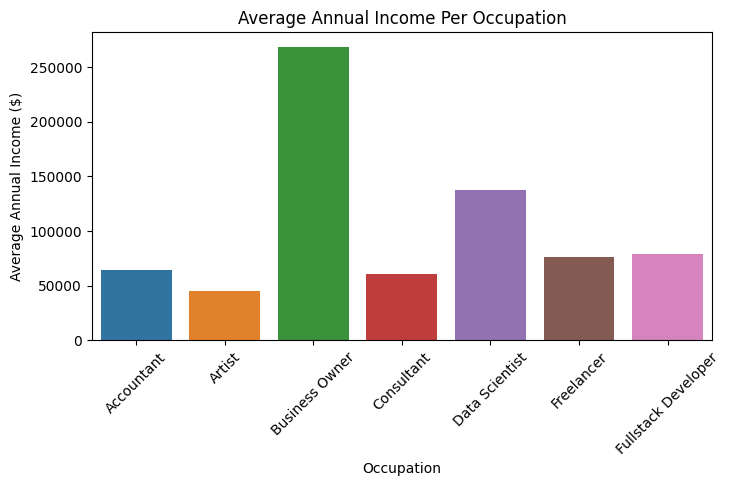

In [340]:
plt.figure(figsize=(8,4))
sns.barplot(x=avg_income_per_occupation.index, y=avg_income_per_occupation.values, palette='tab10')
plt.xticks(rotation=45)
plt.title('Average Annual Income Per Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Annual Income ($)')
plt.show()

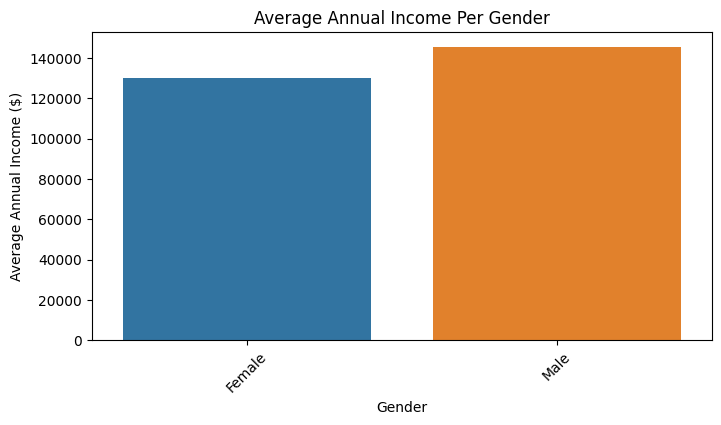

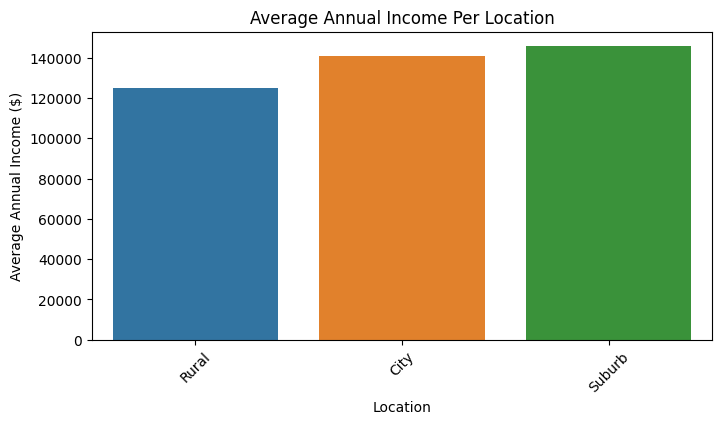

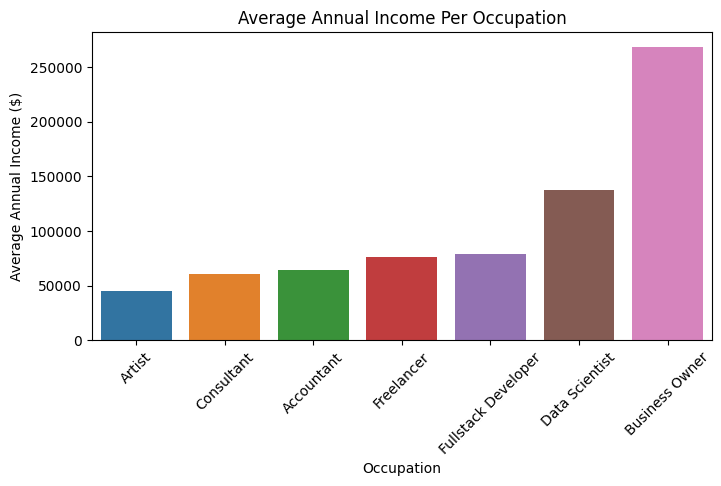

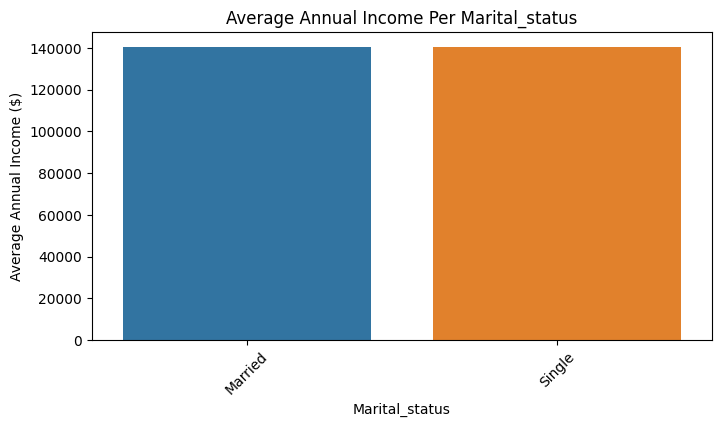

In [341]:
# List of categorical columns
categorical_columns = ['gender', 'location', 'occupation', 'marital_status']

# Loop through each categorical column and plot a bar chart of average annual income
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    avg_income_per_group = df_cust.groupby(col)['annual_income'].mean().sort_values()
    sns.barplot(x=avg_income_per_group.index, y=avg_income_per_group.values, palette='tab10')
    plt.xticks(rotation=45)
    plt.title(f'Average Annual Income Per {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Average Annual Income ($)')
    plt.show()

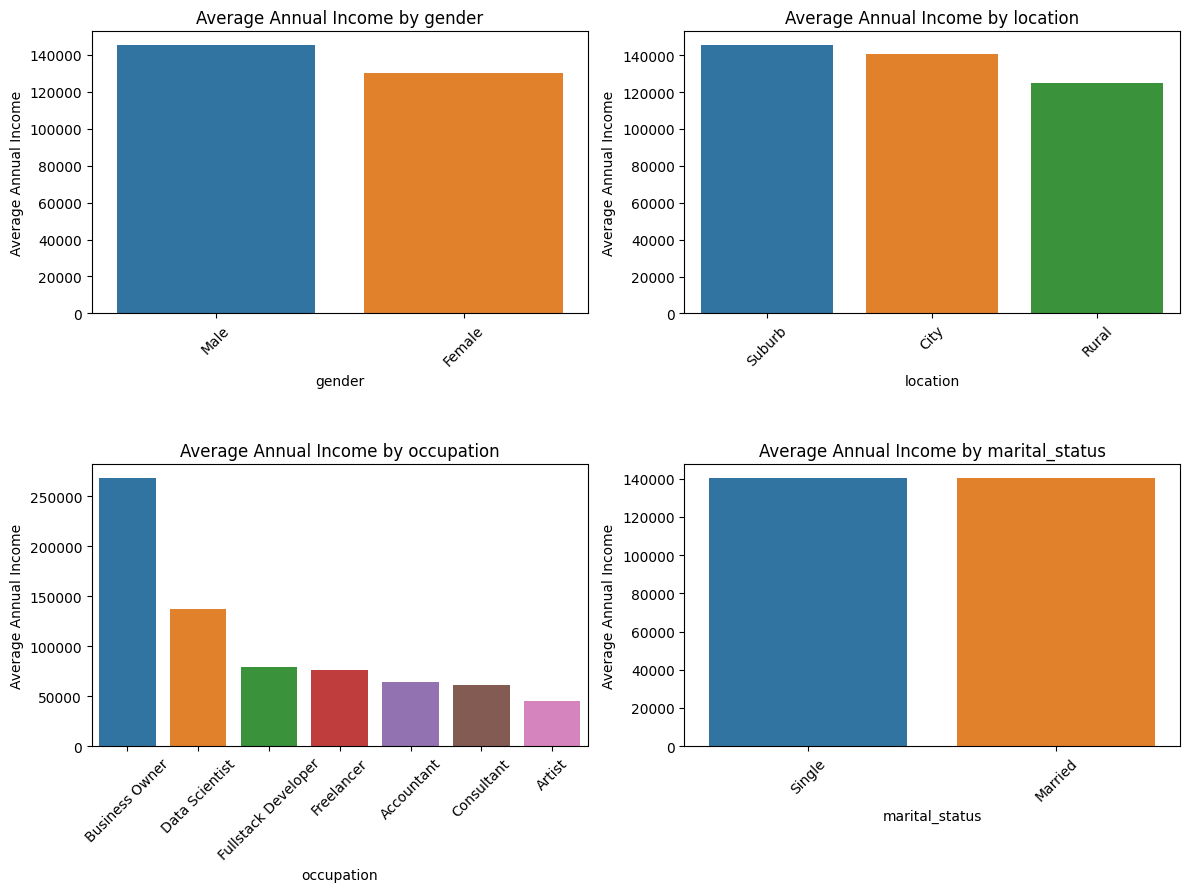

In [342]:
# List of categorical columns
cat_cols = ['gender', 'location', 'occupation', 'marital_status']

num_rows = 3
# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Create subplots for each categorical column
for i, cat_col in enumerate(cat_cols):
    # Calculate the average annual income for each category
    avg_income_by_category = df_cust.groupby(cat_col)['annual_income'].mean().reset_index()
    
    # Sort the data by 'annual_income' before plotting
    sorted_data = avg_income_by_category.sort_values(by='annual_income', ascending=False)
    
    sns.barplot(x=cat_col, y='annual_income', data=sorted_data, ci=None, ax=axes[i], palette='tab10')
    axes[i].set_title(f'Average Annual Income by {cat_col}')
    axes[i].set_xlabel(cat_col)
    axes[i].set_ylabel('Average Annual Income')

    # Rotate x-axis labels for better readability
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Hide any unused subplots
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

<h2 style="color:Blue">2. Analyze Age Column<h2>

### Handle Null Values: Age Column

First let us check if there are any NULL values in the Age column

In [343]:
df_cust.age.isnull().sum()

0

No null values are found in age column. This means we don't need to worry about handling them.

In [344]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,140483.548500
std,288.819436,15.666155,110463.002934
min,1.000000,1.000000,5175.000000
25%,250.750000,26.000000,49620.500000
50%,500.500000,32.000000,115328.000000
75%,750.250000,46.000000,195514.250000
max,1000.000000,135.000000,449346.000000


### Outlier Treatment: Age

Above we see that min age is 1 and max age is 135. These seem to be outliers. So let's find out age distribution.

In [345]:
min_age = df_cust.age.min()
max_age = df_cust.age.max()

min_age, max_age

(1, 135)

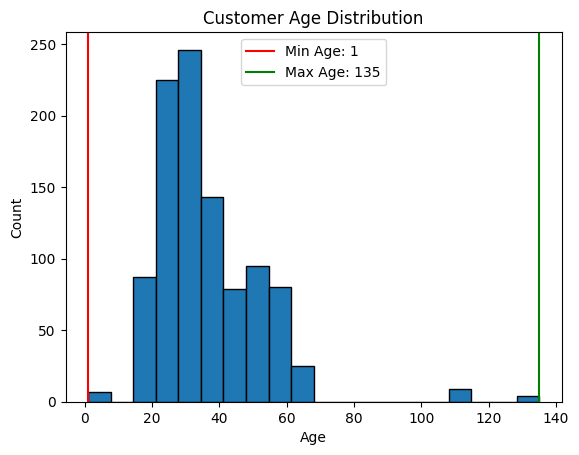

In [346]:
plt.hist(df_cust.age, bins=20, edgecolor='black')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Customer Age Distribution")

plt.axvline(min_age, color="red", label=f"Min Age: {min_age}")
plt.axvline(max_age, color="green", label=f"Max Age: {max_age}")

plt.legend()
plt.show()

From above we will try to find out all customers above 80 and below 15.

In [347]:
df_cust[(df_cust.age<15)|(df_cust.age>80)]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Dhruv Bansal,Female,2,City,Business Owner,358211.0,Married
41,42,Manya Thakur,Male,110,City,Artist,7621.0,Married
165,166,Swara Mehtani,Female,1,City,Freelancer,39721.0,Single
174,175,Sneha Jaiswal,Male,110,City,Freelancer,23723.0,Married
222,223,Aaryan Bajaj,Male,110,Suburb,Freelancer,210987.0,Married
277,278,Amaira Dewan,Male,110,City,Consultant,96522.0,Single
295,296,Veer Anand,Male,1,Rural,Accountant,55254.0,Married
325,326,Yash Chatterjee,Male,110,City,Accountant,61021.0,Single
610,611,Advait Mangal,Male,135,Rural,Business Owner,444776.0,Married
692,693,Aarohi Dubey,Male,1,City,Business Owner,83045.0,Married


In [348]:
outliers = df_cust[(df_cust.age<15)|(df_cust.age>80)]
outliers.shape

(20, 8)

Total 20 outliers for age. Now how can we handle these outliers? 

Possible options,

1. Remove them: This doesn't sound like a good option as we will loose important information
1. Replace outlier values with some appropriate value: We can use mean or median for this

In [349]:
df_cust.age.median()

32.0

Instead of replace it with a median age for all customers, how about we calculate median age per occupation?

In [350]:
outliers.head(3)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Dhruv Bansal,Female,2,City,Business Owner,358211.0,Married
41,42,Manya Thakur,Male,110,City,Artist,7621.0,Married
165,166,Swara Mehtani,Female,1,City,Freelancer,39721.0,Single


As you can see, for business owners median age is 49 whereas artists have youngest age

**We will calculte median per occupation and then use that for replacing outliers**

In [351]:
median_age_per_occupation = df_cust.groupby('occupation')['age'].median()
median_age_per_occupation

occupation
Accountant             31.5
Artist                 26.0
Business Owner         51.0
Consultant             46.0
Data Scientist         32.0
Freelancer             24.0
Fullstack Developer    27.5
Name: age, dtype: float64

In [352]:
for index, row in outliers.iterrows():
    if pd.notnull(row['age']):
        occupation = df_cust.at[index, 'occupation']
        df_cust.at[index, 'age'] = median_age_per_occupation[occupation]

In [353]:
df_cust[(df_cust.age<15)|(df_cust.age>80)]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [354]:
df_cust.age.describe()

count    1000.000000
mean       35.541500
std        12.276634
min        18.000000
25%        26.000000
50%        32.000000
75%        44.250000
max        64.000000
Name: age, dtype: float64

As you can see above, now we don't have any outliers left. min age is 18 and max is 64

In [355]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married
1,2,Kabir Thakur,Female,47.0,City,Consultant,65172.0,Single
2,3,Kriti Mangal,Male,21.0,City,Freelancer,22378.0,Married
3,4,Sara Dwivedi,Male,24.0,Rural,Freelancer,33563.0,Married
4,5,Aarohi Negi,Male,48.0,City,Consultant,39406.0,Married


### Data Visualization: Age Column

In [356]:
# Define the bin edges and labels
bin_edges = [17, 25, 48, 65]  # Adjust as needed
bin_labels = ['18-25', '26-48', '49-65']

# Use the cut function to bin and label the age column
pd.cut(df_cust['age'], bins=bin_edges, labels=bin_labels)

0      49-65
1      26-48
2      18-25
3      18-25
4      26-48
       ...  
995    26-48
996    49-65
997    26-48
998    26-48
999    26-48
Name: age, Length: 1000, dtype: category
Categories (3, object): ['18-25' < '26-48' < '49-65']

In [357]:
# Define the bin edges and labels
bin_edges = [17, 25, 48, 65]  # Adjust as needed
bin_labels = ['18-25', '26-48', '49-65']

# Use the cut function to bin and label the age column
df_cust['age_group'] = pd.cut(df_cust['age'], bins=bin_edges, labels=bin_labels)

In [358]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65
1,2,Kabir Thakur,Female,47.0,City,Consultant,65172.0,Single,26-48
2,3,Kriti Mangal,Male,21.0,City,Freelancer,22378.0,Married,18-25
3,4,Sara Dwivedi,Male,24.0,Rural,Freelancer,33563.0,Married,18-25
4,5,Aarohi Negi,Male,48.0,City,Consultant,39406.0,Married,26-48


In [359]:
df_cust['age_group'].value_counts(normalize=True)*100

age_group
26-48    56.7
18-25    24.6
49-65    18.7
Name: proportion, dtype: float64

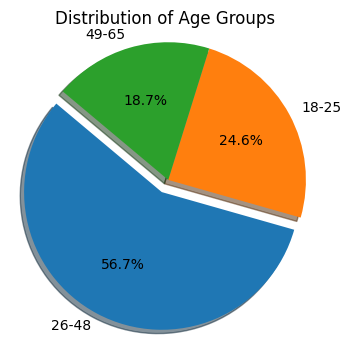

In [360]:
# Calculate the count of values in each age group
age_group_counts = df_cust['age_group'].value_counts(normalize=True) * 100

# Plot the pie chart
plt.figure(figsize=(4, 4))
plt.pie(
    age_group_counts, 
    labels=age_group_counts.index, 
    explode=(0.1,0,0), 
    autopct='%1.1f%%', 
    shadow=True,
    startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Age Groups')
plt.show()

##### More than 50% of customer base are in in age group of 26 - 48 adn ~26% are of age group 18 - 25

<h2 style="color:Blue">3. Analyze Gender and Location Distribution<h2>

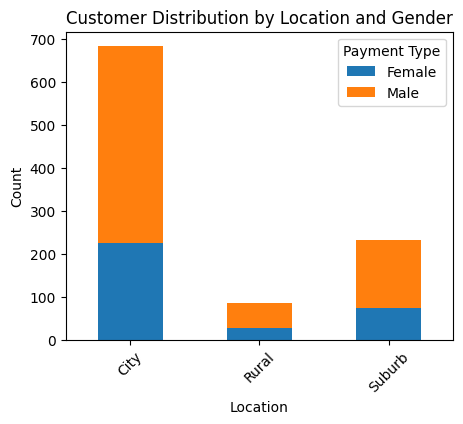

In [361]:
customer_location_gender = df_cust.groupby(['location', 'gender']).size().unstack(fill_value=0)

# Create a stacked bar chart to visualize the distribution of payment types for each occupation
customer_location_gender.plot(kind='bar', stacked=True, figsize=(5, 4))

# Add labels and title
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Customer Distribution by Location and Gender')

# Show the bar chart
plt.legend(title='Payment Type', bbox_to_anchor=(1, 1))  # Add a legend

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

<h1 style="color:purple" align="center">Explore Credit Score Table<h1>

In [362]:
df_cs.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


### Data Cleaning Step 1: Remove Duplicates 

In [363]:
df_cs.shape

(1004, 6)

Hmmm... there are 1004 rows in this dataframe whereas customers dataframe had only 1000. There might be invalid or duplicate data in df_cs

In [364]:
df_cs['cust_id'].nunique()

1000

In [365]:
df_cs.duplicated('cust_id')

0       False
1       False
2       False
3       False
4       False
        ...  
999     False
1000    False
1001    False
1002    False
1003    False
Length: 1004, dtype: bool

In [366]:
df_cs[df_cs.duplicated('cust_id', keep=False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
516,517,308,NaN,NaN,NaN,NaN
517,517,308,0.113860,33.0,3.0,500.0
569,569,344,NaN,NaN,NaN,NaN
570,569,344,0.112599,37.0,0.0,500.0
607,606,734,NaN,NaN,NaN,NaN
608,606,734,0.193418,4392.0,1.0,40000.0
664,662,442,NaN,NaN,NaN,NaN
665,662,442,0.856039,266.0,2.0,500.0


In [367]:
df_cs_clean_1 = df_cs.drop_duplicates(subset='cust_id', keep="last")
df_cs_clean_1.shape

(1000, 6)

In [368]:
df_cs_clean_1[df_cs_clean_1.duplicated('cust_id', keep=False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit


df_cs_clean_1 looks clean now after cleaning duplicates.

Next step would be to see if there are any null values

### Data Cleaning Step 2: Handle Null Values

In [369]:
df_cs_clean_1.isnull().sum()

cust_id                            0
credit_score                       0
credit_utilisation                 0
outstanding_debt                   0
credit_inquiries_last_6_months     0
credit_limit                      65
dtype: int64

Ahh... look at credit_limit. It has a bunch of null values. we need to clean them up! From the business knowledge we know that credit limit depends on credit score of a customer. We will try to find out if we can figure out a mathematical relationship between credit score and credit limit and use credit score to full NULL values in credit limit. Let's explore a few things here!

In [370]:
df_cs_clean_1[df_cs_clean_1.credit_limit.isnull()]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
10,11,679,0.557450,9187.0,2.0,NaN
35,36,790,0.112535,4261.0,1.0,NaN
37,38,514,0.296971,238.0,2.0,NaN
45,46,761,0.596041,24234.0,2.0,NaN
64,65,734,0.473715,13631.0,0.0,NaN
...,...,...,...,...,...,...
912,909,479,0.487555,320.0,3.0,NaN
931,928,311,0.832244,316.0,2.0,NaN
948,945,526,0.272734,227.0,1.0,NaN
954,951,513,0.175914,131.0,3.0,NaN


In [371]:
df_cs_clean_1['credit_limit'].unique()

array([40000.,  1250.,  1000.,   500.,   750.,    nan,  1500., 60000.,
       20000.])

Credit limit has only few unique values. Let's check the count for each of these unique values

In [372]:
df_cs_clean_1['credit_limit'].value_counts()

credit_limit
500.0      229
60000.0    186
40000.0    137
1500.0     100
1000.0      90
750.0       76
1250.0      75
20000.0     42
Name: count, dtype: int64

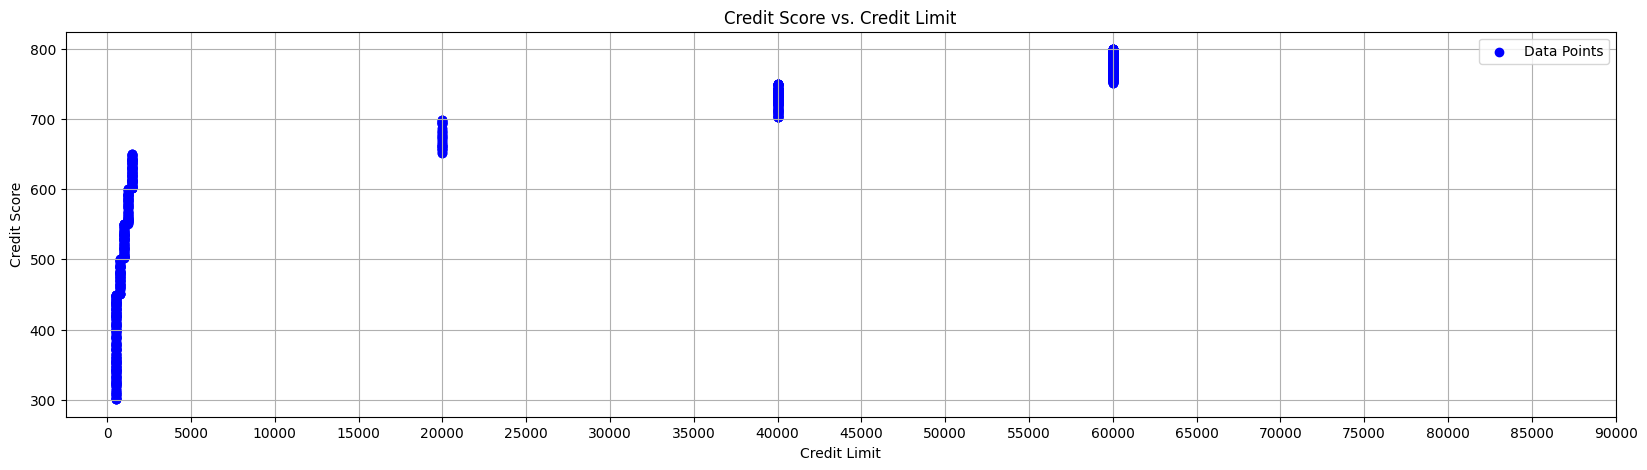

In [373]:
# Looking at scatter plot for credit score vs credit_limit again (after handling oultiers)
# Create a scatter plot
plt.figure(figsize=(20, 5))
plt.scatter(df_cs_clean_1['credit_limit'], df_cs_clean_1['credit_score'], c='blue', marker='o', label='Data Points')

# Customize the plot
plt.title('Credit Score vs. Credit Limit')
plt.xlabel('Credit Limit')
plt.ylabel('Credit Score')

# Adjust the y-axis bin interval to 1000
plt.xticks(range(0, 90001, 5000))
plt.grid(True)

# Show the plot
plt.legend()
plt.show()

Here we can see clear relationship between credit score and credit limit. Where there are levels for example, upto 650 score is getting a very minor credit limit (<1000$) where as a score between 650 to 700 is getting around 20000. Score between 700 to 750 is getting around 40K etc.

In [374]:
# Define bin ranges
bin_ranges = [300, 450, 500, 550, 600, 650, 700, 750, 800]

# Create labels for the bins
bin_labels = [f'{start}-{end-1}' for start, end in zip(bin_ranges, bin_ranges[1:])]

# Use pd.cut to assign data to bins
df_cs_clean_1['credit_score_range'] = pd.cut(df_cs_clean_1['credit_score'], bins=bin_ranges, labels=bin_labels, include_lowest=True, right=False)

In [375]:
df_cs_clean_1.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
0,1,749,0.585171,19571.0,0.0,40000.0,700-749
1,2,587,0.107928,161644.0,2.0,1250.0,550-599
2,3,544,0.854807,513.0,4.0,1000.0,500-549
3,4,504,0.336938,224.0,2.0,1000.0,500-549
4,5,708,0.586151,18090.0,2.0,40000.0,700-749


We can now see a new column called credit_score_range whcih is calculated based on the credit_score column

In [376]:
df_cs_clean_1[['credit_score','credit_score_range', 'credit_limit']].head(3)

,credit_score,credit_score_range,credit_limit
0,749,700-749,40000.0
1,587,550-599,1250.0
2,544,500-549,1000.0


In [377]:
df_cs_clean_1[df_cs_clean_1['credit_score_range']=="750-799"]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
21,22,785,0.897089,36083.0,3.0,60000.0,750-799
25,26,758,0.250811,190838.0,2.0,60000.0,750-799
26,27,766,0.830908,31344.0,3.0,60000.0,750-799
29,30,798,0.222597,7238.0,2.0,60000.0,750-799
31,32,768,0.747793,35109.0,2.0,60000.0,750-799
...,...,...,...,...,...,...,...
988,985,770,0.628088,33405.0,2.0,60000.0,750-799
993,990,772,0.259958,11937.0,2.0,60000.0,750-799
996,993,782,0.477170,20305.0,2.0,60000.0,750-799
1000,997,774,0.465462,17139.0,0.0,60000.0,750-799


In [378]:
df_cs_clean_1[df_cs_clean_1['credit_score_range']=="300-449"]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
5,6,442,0.705409,246.0,4.0,500.0,300-449
11,12,429,0.627645,263.0,0.0,500.0,300-449
15,16,347,0.531660,190.0,0.0,500.0,300-449
18,19,447,0.795650,292.0,1.0,500.0,300-449
20,21,381,0.714710,307.0,0.0,500.0,300-449
...,...,...,...,...,...,...,...
981,978,371,0.435307,183.0,2.0,500.0,300-449
982,979,332,0.150815,65.0,1.0,500.0,300-449
984,981,327,0.377202,108.0,3.0,500.0,300-449
989,986,425,0.178470,56.0,4.0,500.0,300-449


Above you can see that for credit score range "750-799" the credit limit is 60K whereas for "300-449" it is 500. We can use MODE function to find out most frequently occuring credit limit for a given score range.

In [379]:
mode_df = df_cs_clean_1.groupby('credit_score_range')['credit_limit'].agg(lambda x: x.mode().iloc[0]).reset_index()
mode_df

,credit_score_range,credit_limit
0,300-449,500.0
1,450-499,750.0
2,500-549,1000.0
3,550-599,1250.0
4,600-649,1500.0
5,650-699,20000.0
6,700-749,40000.0
7,750-799,60000.0


In [380]:
df_cs_clean_1[df_cs_clean_1.credit_limit.isnull()].sample(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
783,780,787,0.681978,24711.0,1.0,NaN,750-799
469,470,795,0.776496,33523.0,4.0,NaN,750-799
276,277,781,0.459545,24618.0,1.0,NaN,750-799


In [381]:
# Merge the mode values back with the original DataFrame
df_cs_clean_2 = pd.merge(df_cs_clean_1, mode_df, on='credit_score_range', suffixes=('', '_mode'))
df_cs_clean_2.sample(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
72,526,713,0.158635,5259.0,2.0,40000.0,700-749,40000.0
37,279,741,0.352932,10846.0,1.0,NaN,700-749,40000.0
377,246,430,0.744435,263.0,2.0,500.0,300-449,500.0


In [382]:
df_cs_clean_2[df_cs_clean_2.credit_limit.isnull()].sample(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
101,726,737,0.136048,205404.0,4.0,NaN,700-749,40000.0
693,115,619,0.128910,151.0,1.0,NaN,600-649,1500.0
485,677,300,0.785509,341.0,1.0,NaN,300-449,500.0


Above we can simple replace NaN value in credit_limit column with credit_limit_mode value. This value indicates most frequently occuring credit limit for a given credit_score_range. Hence it can be used as a replacement value.

We will create a new copy of the dataframe so that we have reproducibility and access of the older dataframe in this notebook

In [383]:
df_cs_clean_3 = df_cs_clean_2.copy()
df_cs_clean_3['credit_limit'].fillna(df_cs_clean_3['credit_limit_mode'], inplace=True)
df_cs_clean_3.shape

(1000, 8)

In [384]:
df_cs_clean_3.isnull().sum()

cust_id                           0
credit_score                      0
credit_utilisation                0
outstanding_debt                  0
credit_inquiries_last_6_months    0
credit_limit                      0
credit_score_range                0
credit_limit_mode                 0
dtype: int64

You can now see ZERO outliers in credit_limit column which means we successfully got rid of all NULL values. Hurray! 🥳

In [385]:
df_cs_clean_3[df_cs_clean_3.cust_id==117]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
347,117,372,0.604427,252.0,4.0,500.0,300-449,500.0


Previously customer id 5 had null value in credit_limit. Now it has a valid value

### Data Cleaning Step 3: Handle Outliers: outstanding_debt

In [386]:
df_cs_clean_3.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_limit_mode
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,589.182000,0.498950,9683.597000,1.955000,19733.75000,19912.500000
std,288.819436,152.284929,0.233139,25255.893671,1.414559,24717.43818,24840.914633
min,1.000000,300.000000,0.103761,33.000000,0.000000,500.00000,500.000000
25%,250.750000,460.000000,0.293917,221.000000,1.000000,750.00000,750.000000
50%,500.500000,601.500000,0.487422,550.000000,2.000000,1500.00000,1500.000000
75%,750.250000,738.000000,0.697829,11819.500000,3.000000,40000.00000,40000.000000
max,1000.000000,799.000000,0.899648,209901.000000,4.000000,60000.00000,60000.000000


When we observe min and max for various columns, we realize that outstanding_debt's max is greater than the max of credit_limit. Based on the business understanding, we know that the maximum debt that a customer can have is equal to credit limit. They would not be allowed to spend more than their credit limit. Let's see how many such cases are present in our dataset

**Visualizing outliers**

Text(0.5, 1.0, 'Box plot for outstanding debt')

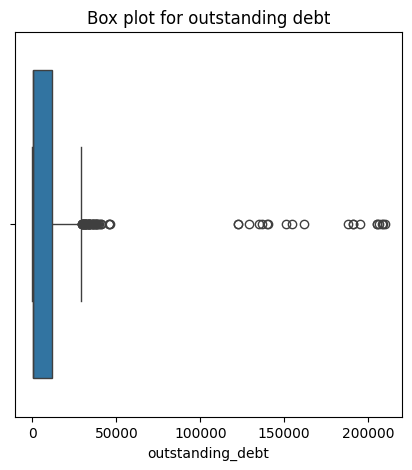

In [387]:
plt.figure(figsize=(5, 5))
sns.boxplot(x=df_cs_clean_3['outstanding_debt'])
plt.title('Box plot for outstanding debt')

Instead of using any statistical approach (such as standard deviation or IQR), here too we will use a business knowledge. We will mark any outstanding debt that is greater than credit limit as an outlier

In [388]:
df_cs_clean_3[df_cs_clean_3.outstanding_debt>df_cs_clean_3.credit_limit]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
6,39,734,0.573023,122758.0,3.0,40000.0,700-749,40000.0
12,94,737,0.739948,137058.0,2.0,40000.0,700-749,40000.0
35,272,703,0.446886,154568.0,1.0,40000.0,700-749,40000.0
41,302,722,0.608076,122402.0,4.0,40000.0,700-749,40000.0
101,726,737,0.136048,205404.0,4.0,40000.0,700-749,40000.0
142,2,587,0.107928,161644.0,2.0,1250.0,550-599,1250.0
363,205,303,0.364360,187849.0,0.0,500.0,300-449,500.0
406,351,320,0.285081,150860.0,0.0,500.0,300-449,500.0
474,637,420,0.323984,140063.0,4.0,500.0,300-449,500.0
604,647,498,0.658087,128818.0,3.0,750.0,450-499,750.0


We will replace these outliers with credit_limit. We can assume that there was some data processing error due to we got these high numbers and it is ok to replace them with a credit_limit

In [389]:
df_cs_clean_3.loc[df_cs_clean_3['outstanding_debt'] > df_cs_clean_3['credit_limit'], 'outstanding_debt']

6      122758.0
12     137058.0
35     154568.0
41     122402.0
101    205404.0
142    161644.0
363    187849.0
406    150860.0
474    140063.0
604    128818.0
609    140008.0
615    195004.0
684    205014.0
759    209901.0
788    190838.0
858    208898.0
877    206191.0
903    135112.0
930    190717.0
968    208406.0
Name: outstanding_debt, dtype: float64

In [390]:
df_cs_clean_3.loc[df_cs_clean_3['outstanding_debt'] > df_cs_clean_3['credit_limit'], 'outstanding_debt'] = df_cs_clean_3['credit_limit']

In [391]:
df_cs_clean_3.loc[[55,66]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
55,408,737,0.354976,7223.0,4.0,40000.0,700-749,40000.0
66,489,743,0.195717,6660.0,4.0,40000.0,700-749,40000.0


In [392]:
df_cs_clean_3[df_cs_clean_3.outstanding_debt>df_cs_clean_3.credit_limit]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode


All outliers in column outstanding_debt are now GONE. Hurray 🙌🏼😀

In [393]:
df_cs_clean_3.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_limit_mode
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,589.182000,0.498950,6850.084000,1.955000,19733.75000,19912.500000
std,288.819436,152.284929,0.233139,10683.473561,1.414559,24717.43818,24840.914633
min,1.000000,300.000000,0.103761,33.000000,0.000000,500.00000,500.000000
25%,250.750000,460.000000,0.293917,221.000000,1.000000,750.00000,750.000000
50%,500.500000,601.500000,0.487422,541.500000,2.000000,1500.00000,1500.000000
75%,750.250000,738.000000,0.697829,10924.500000,3.000000,40000.00000,40000.000000
max,1000.000000,799.000000,0.899648,60000.000000,4.000000,60000.00000,60000.000000


### Data Exploration: Visualizing Correlation in Credit Score Table

In [394]:
df_cust.head(2)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65
1,2,Kabir Thakur,Female,47.0,City,Consultant,65172.0,Single,26-48


In [395]:
df_cs_clean_3.head(2)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
0,1,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0
1,5,708,0.586151,18090.0,2.0,40000.0,700-749,40000.0


In [396]:
df_merged = df_cust.merge(df_cs_clean_3, on='cust_id', how='inner')
df_merged.head(2)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
0,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0
1,2,Kabir Thakur,Female,47.0,City,Consultant,65172.0,Single,26-48,587,0.107928,1250.0,2.0,1250.0,550-599,1250.0


In [397]:
numerical_cols = ['credit_score', 'credit_utilisation', 'outstanding_debt', 'credit_limit', 'annual_income','age']

correlation_matrix = df_merged[numerical_cols].corr()
correlation_matrix

,credit_score,credit_utilisation,outstanding_debt,credit_limit,annual_income,age
credit_score,1.000000,-0.070445,0.680654,0.847952,0.575751,0.444917
credit_utilisation,-0.070445,1.000000,0.192838,-0.080493,-0.086368,-0.027713
outstanding_debt,0.680654,0.192838,1.000000,0.810581,0.555661,0.444301
credit_limit,0.847952,-0.080493,0.810581,1.000000,0.684775,0.510993
annual_income,0.575751,-0.086368,0.555661,0.684775,1.000000,0.619037
age,0.444917,-0.027713,0.444301,0.510993,0.619037,1.000000


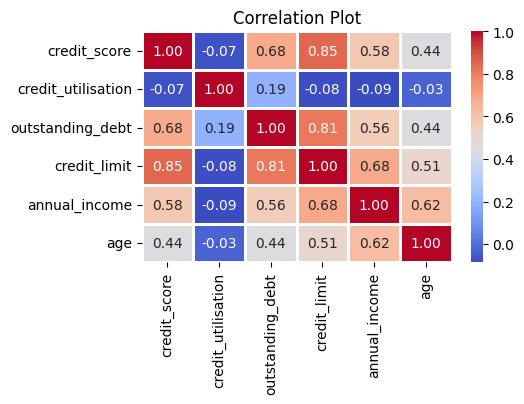

In [398]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.8)
plt.title('Correlation Plot')
plt.show()

You can see a high correlation between credit limit and credit score (~0.85)

Also credit limit and annual income has a high correlation.

This correlation table can be used for further analysis. It shows if one variable has relationship with the other variable

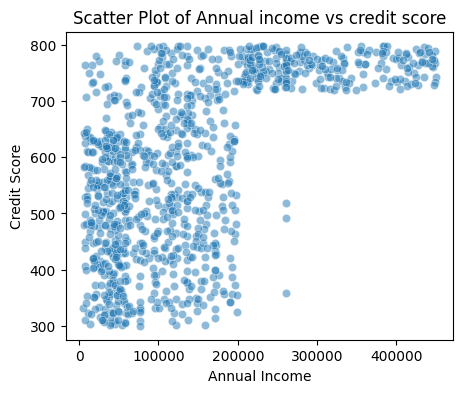

In [399]:
# Just looking if there is any relation between annual_income and credit score
plt.figure(figsize=(5, 4))
sns.scatterplot(x='annual_income', y='credit_score', data=df_merged, alpha=0.5)
plt.title('Scatter Plot of Annual income vs credit score')
plt.xlabel('Annual Income')
plt.ylabel('Credit Score')
plt.show()

##### No clear pattern observed

<h1 style="color:purple" align="center">Transactions Table<h1>

In [400]:
df_trans.head(2)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card


In [401]:
df_trans.shape

(500000, 7)

### Data Cleaning Step 1: Handle NULL Values: platform column

In [403]:
df_trans.isnull().sum()

tran_id                0
cust_id                0
tran_date              0
tran_amount            0
platform            4941
product_category       0
payment_type           0
dtype: int64

platform has a lot of null values. Let's check them further

In [404]:
df_trans[df_trans.platform.isnull()]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
355,356,58,2023-01-01,237,None,Electronics,Net Banking
418,419,383,2023-01-01,338,None,Electronics,Credit Card
607,608,421,2023-01-01,700,None,Electronics,Phonepe
844,845,945,2023-01-01,493,None,Sports,Credit Card
912,913,384,2023-01-01,85,None,Fashion & Apparel,Phonepe
...,...,...,...,...,...,...,...
499579,499580,924,2023-09-05,31,None,Fashion & Apparel,Gpay
499646,499647,944,2023-09-05,58445,None,Fashion & Apparel,Phonepe
499725,499726,620,2023-09-05,15,None,Sports,Net Banking
499833,499834,616,2023-09-05,97,None,Fashion & Apparel,Credit Card


<Axes: xlabel='count', ylabel='product_category'>

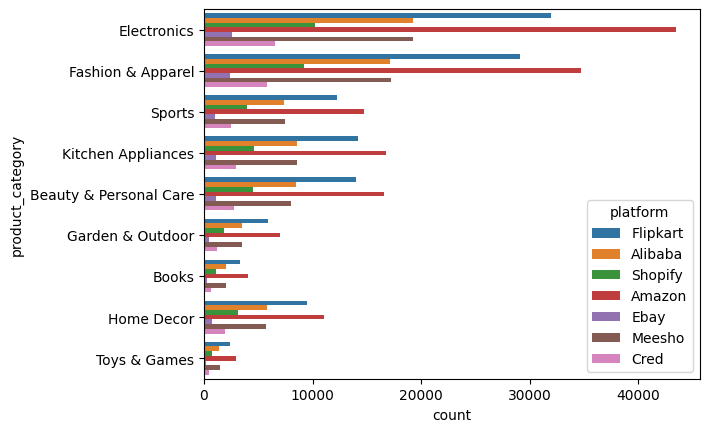

In [405]:
sns.countplot(y='product_category', hue='platform', data=df_trans)

In the above chart, you can see that in all product categories Amazon is the platform that is used the most for making purchases. For handling null values in platform may be we can just replace them using "Amazon" as a product platform just because it is used most frequently

In [406]:
df_trans.platform.mode()

0    Amazon
Name: platform, dtype: object

In [407]:
df_trans.platform.mode()[0]

'Amazon'

In [408]:
df_trans['platform'].fillna(df_trans.platform.mode()[0], inplace=True)

In [409]:
df_trans.isnull().sum()

tran_id             0
cust_id             0
tran_date           0
tran_amount         0
platform            0
product_category    0
payment_type        0
dtype: int64

Once again we got rid of NULL values 🥳🎄🎈🎈

### Data Cleaning Step 2: Treat Outliers: tran_amount

In [410]:
df_trans.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.00000
mean,250000.500000,501.400428,3225.20733
std,144337.711635,288.641924,13098.74276
min,1.000000,1.000000,0.00000
25%,125000.750000,252.000000,64.00000
50%,250000.500000,502.000000,141.00000
75%,375000.250000,752.000000,397.00000
max,500000.000000,1000.000000,69999.00000


We can see transactions with 0 amount. These seem to be invalid

In [280]:
df_trans_zero = df_trans[df_trans.tran_amount==0]
df_trans_zero.head(3)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
120,121,440,2023-01-01,0,Amazon,Electronics,Credit Card
141,142,839,2023-01-01,0,Amazon,Electronics,Credit Card
517,518,147,2023-01-01,0,Amazon,Electronics,Credit Card


In [281]:
df_trans_zero.shape

(4734, 7)

In [282]:
df_trans_zero.platform.value_counts()

platform
Amazon    4734
Name: count, dtype: int64

In [283]:
df_trans_zero[['platform','product_category','payment_type']].value_counts()

platform  product_category  payment_type
Amazon    Electronics       Credit Card     4734
Name: count, dtype: int64

It appears that when platform=Amazon, product_category=Eletronics and payment_type=Credit Card, at that time we get all these zero transactions. We need to find other transactions in this group and find its median to replace these zero values. We are not using mean because we can see some outliers as well in this column

In [284]:
df_trans_1 = df_trans[(df_trans.platform=='Amazon')&(df_trans.product_category=="Electronics")&(df_trans.payment_type=="Credit Card")]
df_trans_1.shape

(15288, 7)

In [285]:
df_trans_1[df_trans_1.tran_amount>0]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
109,110,887,2023-01-01,635,Amazon,Electronics,Credit Card
173,174,676,2023-01-01,60439,Amazon,Electronics,Credit Card
190,191,763,2023-01-01,697,Amazon,Electronics,Credit Card
263,264,528,2023-01-01,421,Amazon,Electronics,Credit Card
311,312,936,2023-01-01,537,Amazon,Electronics,Credit Card
...,...,...,...,...,...,...,...
499766,499767,723,2023-09-05,909,Amazon,Electronics,Credit Card
499793,499794,586,2023-09-05,304,Amazon,Electronics,Credit Card
499812,499813,688,2023-09-05,425,Amazon,Electronics,Credit Card
499860,499861,373,2023-09-05,480,Amazon,Electronics,Credit Card


In [286]:
median_to_replace = df_trans_1[df_trans_1.tran_amount>0].tran_amount.median()
median_to_replace

554.0

In [287]:
df_trans['tran_amount'].replace(0,median_to_replace, inplace=True)

In [288]:
df_trans[df_trans.tran_amount==0]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type


As you can see above, no zero values are left in tran_amount column

In [289]:
df_trans.tran_amount.describe()

count    500000.000000
mean       3230.452602
std       13097.561071
min           2.000000
25%          66.000000
50%         146.000000
75%         413.000000
max       69999.000000
Name: tran_amount, dtype: float64

In [290]:
df_trans[df_trans['tran_amount']<1000].describe()

,tran_id,cust_id,tran_amount
count,475000.000000,475000.000000,475000.000000
mean,250041.699922,501.375499,240.667608
std,144285.259913,288.606185,244.487110
min,1.000000,1.000000,2.000000
25%,125126.750000,252.000000,63.000000
50%,250100.500000,502.000000,131.000000
75%,374928.250000,751.000000,348.000000
max,500000.000000,1000.000000,999.000000


In [165]:
Q1, Q3 = df_trans['tran_amount'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower = Q1 - 2 * IQR
upper = Q3 + 2 * IQR

lower, upper

(-628.0, 1107.0)

In [166]:
df_trans[df_trans.tran_amount<upper].tran_amount.max()

999

In [167]:
df_trans[df_trans.tran_amount>upper].tran_amount.min()

50000

In [168]:
df_trans_outliers = df_trans[df_trans.tran_amount>=upper]
df_trans_outliers

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,61963,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,57869,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,52881,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,58574,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,51669,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,55131,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,59679,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,60184,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,54678,Meesho,Sports,Gpay


In [169]:
df_trans_normal = df_trans[df_trans.tran_amount<upper]
df_trans_normal

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking
...,...,...,...,...,...,...,...
499994,499995,679,2023-09-05,59,Ebay,Beauty & Personal Care,Gpay
499995,499996,791,2023-09-05,43,Amazon,Books,Phonepe
499997,499998,57,2023-09-05,224,,Garden & Outdoor,Phonepe
499998,499999,629,2023-09-05,538,Flipkart,Home Decor,Gpay


In [170]:
tran_mean_per_category = df_trans_normal.groupby("product_category")["tran_amount"].mean()
tran_mean_per_category

product_category
Beauty & Personal Care     92.167205
Books                      29.553515
Electronics               510.172685
Fashion & Apparel          64.553463
Garden & Outdoor          125.630277
Home Decor                302.487561
Kitchen Appliances        176.773288
Sports                    269.181631
Toys & Games               50.333298
Name: tran_amount, dtype: float64

In [171]:
df_trans.loc[df_trans_outliers.index]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,61963,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,57869,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,52881,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,58574,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,51669,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,55131,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,59679,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,60184,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,54678,Meesho,Sports,Gpay


In [172]:
df_trans.loc[df_trans_outliers.index, 'tran_amount'] = df_trans_outliers['product_category'].map(tran_mean_per_category)

In [173]:
df_trans.loc[df_trans_outliers.index]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,92.167205,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,50.333298,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,176.773288,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,64.553463,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,176.773288,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,64.553463,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,64.553463,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,269.181631,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,269.181631,Meesho,Sports,Gpay


You can now see that we got rid of outliers from tran_amount column. Great job folks 👍🏼🔥🔥

<Axes: xlabel='tran_amount', ylabel='Count'>

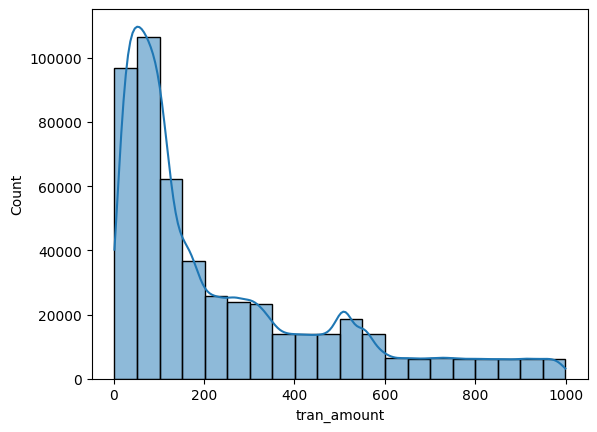

In [174]:
sns.histplot(x='tran_amount', data=df_trans, bins=20, kde=True)

Above shows the histogram of transactions after the removal of outliers. You can see that distribution is right skewed. Transaction amount now is less than 1000

### Data Visualization: Payment Type Distribution

In [422]:
df_trans.head(3)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe


<Axes: xlabel='payment_type', ylabel='percent'>

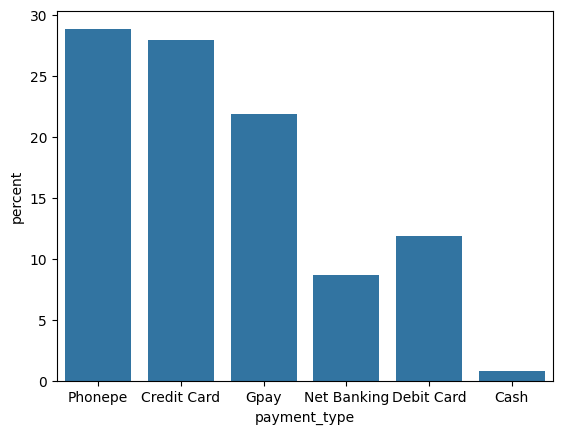

In [415]:
sns.countplot(x=df_trans.payment_type, stat='percent')

**Distribution of payment types across age groups**

In [416]:
df_merged_2 = df_merged.merge(df_trans, on='cust_id', how='inner')
df_merged_2.head(3)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,...,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode,tran_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1283,2023-01-01,30,Shopify,Fashion & Apparel,Net Banking
1,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1382,2023-01-01,96,Amazon,Sports,Debit Card
2,1,Dhruv Bansal,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1521,2023-01-01,86,Meesho,Garden & Outdoor,Gpay


In [417]:
df_merged_2.shape

(500000, 22)

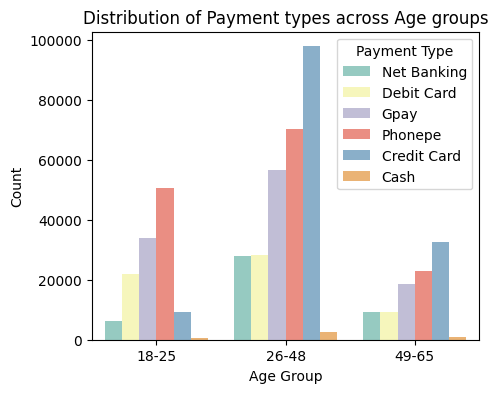

In [418]:
plt.figure(figsize=(5, 4))
sns.countplot(x='age_group', hue='payment_type', data=df_merged_2, palette='Set3')
plt.title('Distribution of Payment types across Age groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Payment Type', loc='upper right')

plt.show()

From above analysis, we can see that age group 18-25 has less exposure to credit cards compared to other groups

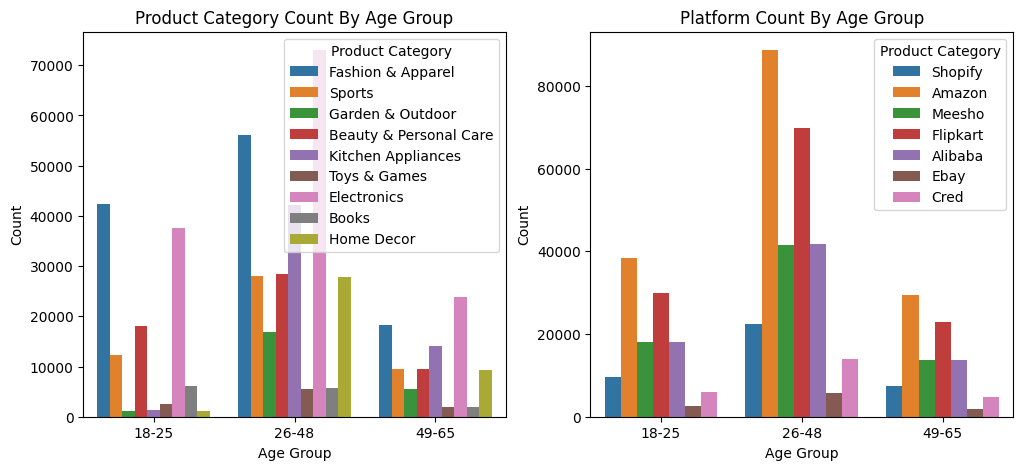

In [419]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

sns.countplot(x='age_group', hue="product_category", data=df_merged_2, ax=ax1)
ax1.set_title("Product Category Count By Age Group")
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Count")
ax1.legend(title="Product Category", loc='upper right')

sns.countplot(x='age_group', hue="platform", data=df_merged_2, ax=ax2)
ax2.set_title("Platform Count By Age Group")
ax2.set_xlabel("Age Group")
ax2.set_ylabel("Count")
ax2.legend(title="Product Category", loc='upper right')

plt.show()

### Observations:

1. Top 3 purchasing categories of customers in age group (18 -25) : Electronics, Fashion & Apparel, Beauty & personal care
1. Top platforms : Amazon, Flipkart, Alibaba

### Data Visualization: Average Transaction Amount

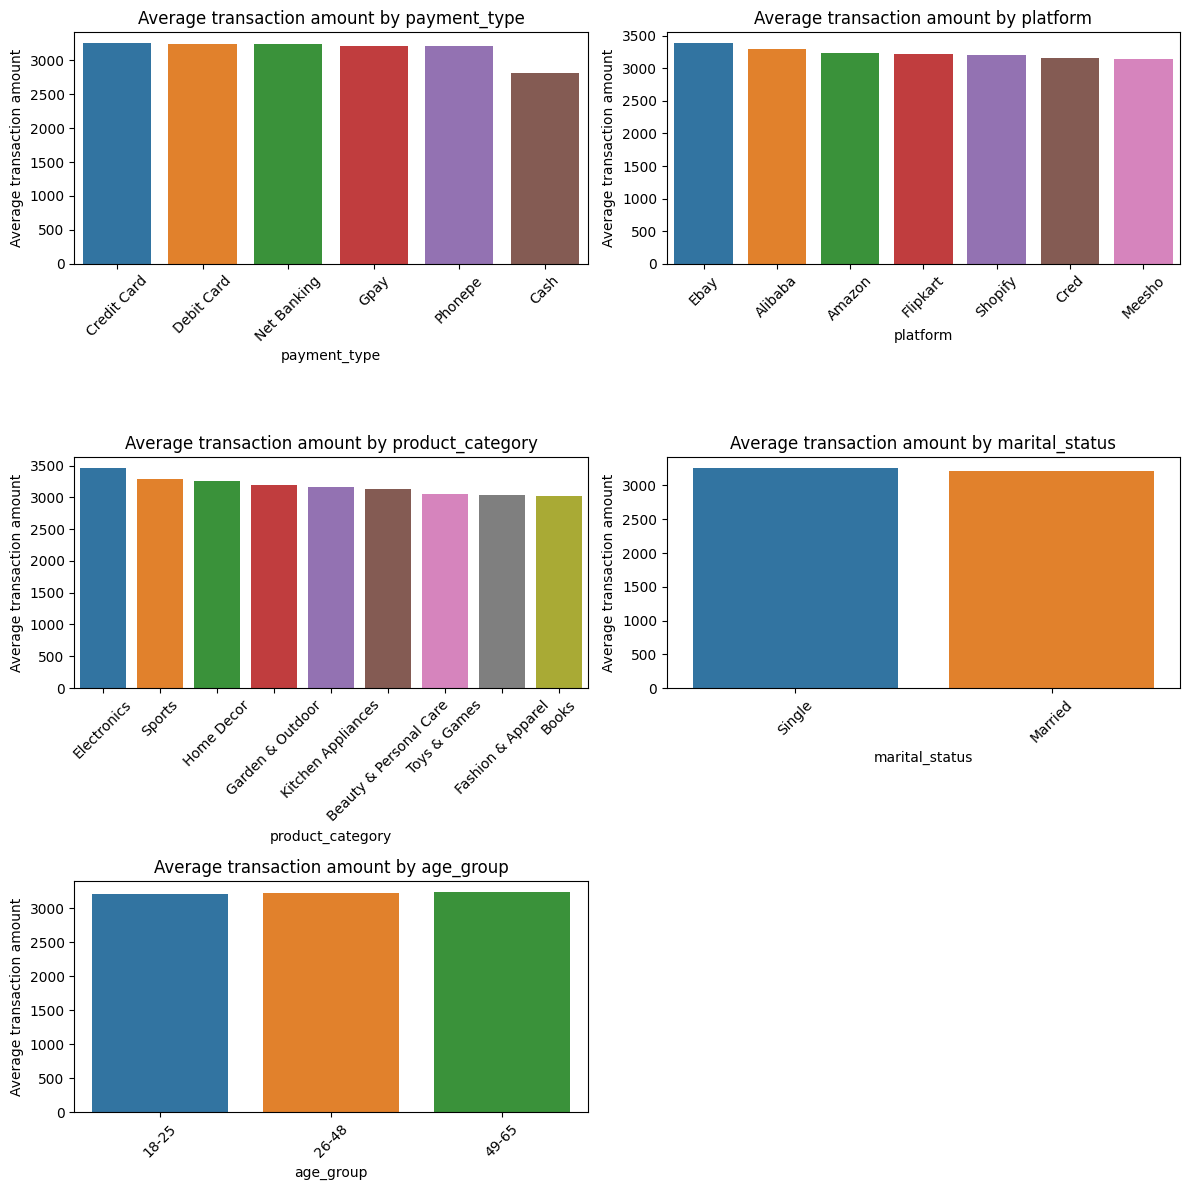

In [421]:
# List of categorical columns
cat_cols = ['payment_type', 'platform', 'product_category', 'marital_status', 'age_group']

num_rows = 3
# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Create subplots for each categorical column
for i, cat_col in enumerate(cat_cols):
    # Calculate the average annual income for each category
    avg_tran_amount_by_category = df_merged_2.groupby(cat_col)['tran_amount'].mean().reset_index()
    
    # Sort the data by 'annual_income' before plotting
    sorted_data = avg_tran_amount_by_category.sort_values(by='tran_amount', ascending=False)
    
    sns.barplot(x=cat_col, y='tran_amount', data=sorted_data, ci=None, ax=axes[i], palette='tab10')
    axes[i].set_title(f'Average transaction amount by {cat_col}')
    axes[i].set_xlabel(cat_col)
    axes[i].set_ylabel('Average transaction amount')

    # Rotate x-axis labels for better readability
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Hide any unused subplots
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

In [131]:
df_trans.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.000000
mean,250000.500000,500.577940,241.473582
std,144337.711635,288.739056,243.267746
min,1.000000,1.000000,2.000000
25%,125000.750000,250.000000,64.607934
50%,250000.500000,501.000000,132.000000
75%,375000.250000,750.000000,351.000000
max,500000.000000,1000.000000,999.000000


### Further Analysis On Age Group

Let us do further analysis on age group to figure out their average income, credit limit, credit score etc

In [429]:
# Group the data by age group and calculate the average credit_limit and credit_score
age_group_metrics = df_merged.groupby('age_group')[['annual_income', 'credit_limit', 'credit_score']].mean().reset_index()
age_group_metrics

,age_group,annual_income,credit_limit,credit_score
0,18-25,37091.235772,1130.081301,484.451220
1,26-48,145869.623457,20560.846561,597.569665
2,49-65,260165.925134,41699.197861,701.524064


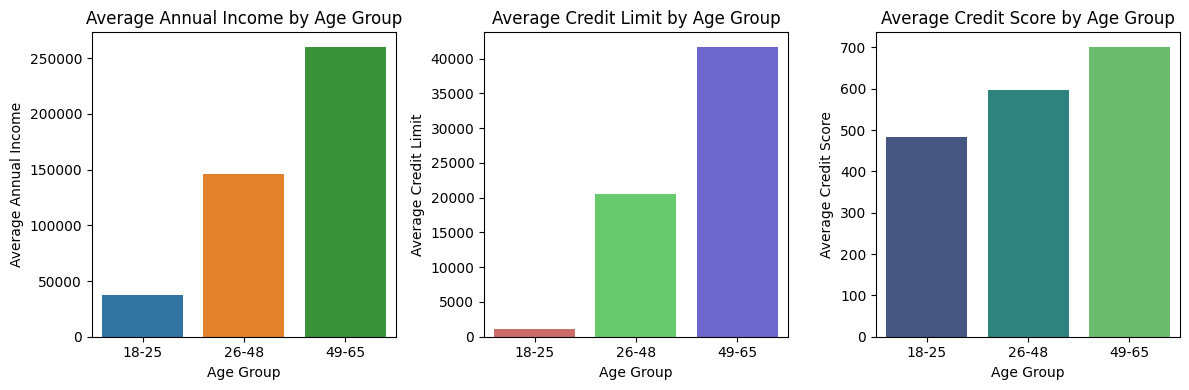

In [439]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Average annual income by age group
sns.barplot(x='age_group', y='annual_income', data=age_group_metrics, palette='tab10', ax=ax1)
ax1.set_title('Average Annual Income by Age Group')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Average Annual Income')
ax1.tick_params(axis='x', rotation=0)

# Plot 2: Average Max Credit Limit by Age Group
sns.barplot(x='age_group', y='credit_limit', data=age_group_metrics, palette='hls', ax=ax2)
ax2.set_title('Average Credit Limit by Age Group')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Average Credit Limit')
ax2.tick_params(axis='x', rotation=0)

# Plot 3: Average Credit Score by Age Group
sns.barplot(x='age_group', y='credit_score', data=age_group_metrics, palette='viridis', ax=ax3)
ax3.set_title('Average Credit Score by Age Group')
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Average Credit Score')
ax3.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

<h2 align="center", style="color:purple">Finalize Target Market For a Trial Credit Card Launch<h2>

#### Targeting Untapped market

![image-2.png](image-2.png)

1. People with age group of 18 -25 accounts to ~26% of customer base in the data
2. Avg annual income of this group is less than 50k
3. They don't have much credit history which is getting reflected in their credit score and credit limit 
4. Usage of credit cards as payment type is relatively low compared to other groups
5. Top 3 most shopping products categories : Electronics, Fashion & Apparel, Beauty & Personal care